# Project: Uncertainty Estimation - Review

## O. Libraries & Setup

First, we import the necessary libraries:

In [167]:
# deep learning
import torch
import torch.nn as nn
# import torchbnn as bnn
import torch.nn.functional as F

# data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other
import tqdm as tqdm

Then, we setup the device for the NN training:

In [168]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


Finally, we create a function that contains some noise. This could be seen as noise coming from the model:

In [169]:
# Define the function to be modeled
def f(x):
    return x + np.random.normal(0, 0.1, x.shape[0]) * x ** 2

# def f(x):
#     y = np.zeros_like(x)

#     for i in range(len(x)):
#         if -10 <= x[i] < -5:
#             noise = np.random.normal(0, 0.5)
#         elif -5 <= x[i] < 0:
#             noise = np.random.normal(0, 0.012)
#         elif 0 <= x[i] < 5:
#             noise = np.random.normal(0, 1.5)
#         elif 5 <= x[i] <= 10:
#             noise = np.random.normal(0, 0.5)
#         else:
#             noise = 0
        
#         mean = np.sin(x[i] / 2) + x[i] * np.cos(0.8 * x[i])
#         y[i] = mean + noise
    
#     return y

# def f(x):
#     return x*np.sin(x) + np.random.normal(0, 0.3)*x + np.random.normal(0, 0.3)

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)# np.random.uniform(low=0, high=10, size=1000)  # Adjust the range as needed

# Generate target data using the function f(x)
y = f(X)

X_ood = np.linspace(5, 10, num=200, endpoint=True) # np.random.uniform(low=10, high=15, size=200)
y_ood = f(X_ood)

Plotting the function:

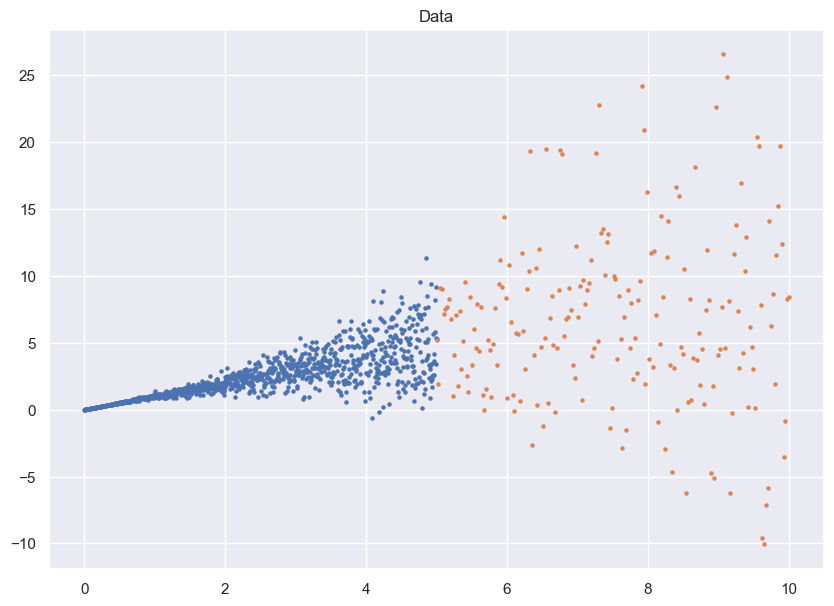

In [170]:
# plot 
sns.set(rc={'figure.figsize':(10, 7)})
plt.scatter(X, y, s=5)
plt.scatter(X_ood, y_ood, s=5)
plt.title("Data")
plt.show()

Finally, we split the dataset into training and testing and convert everything to torch tensors:

In [171]:
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# convert to tensor
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

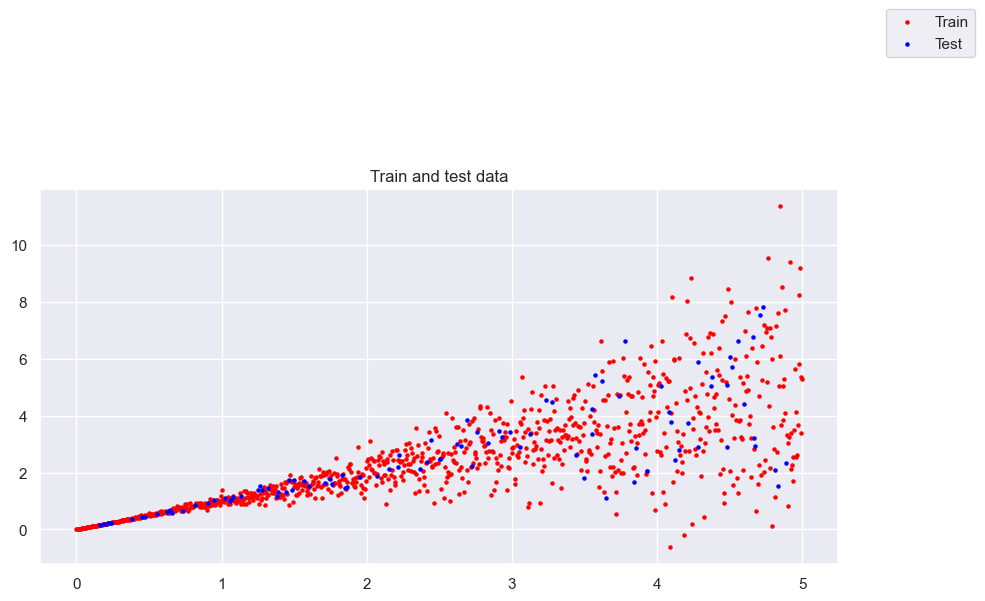

In [172]:
# plot train and test data
plt.scatter(X_train, y_train, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
plt.title("Train and test data")
plt.tight_layout()
plt.show()

## I. Monte-Carlo Dropout

This method is the easiest to implement as it does not require any major modification of the architecture of the Neural Network

In [173]:
# # custom loss fonction Gaussian negative log-likelihood
# def gaussian_nll(y_pred, y_true):
#     mu = y_pred[:, 0]
#     sigma = y_pred[:, 1]
#     loss = (sigma + torch.square(y_true - mu) / torch.exp(sigma))/2
#     return torch.mean(loss)

Loss function:
$$-log p_\theta (y_n | x_n) = \frac{log \sigma_\theta^2(x)}{2} + \frac{(y - \mu_\theta(x))^2}{2\sigma_\theta^2} + constant$$

To ensure positivity on the variance, we pass it on *softplus* function: $log(1 + exp(\cdot))$ and add a minimum variance $10^{-6}$ for stability

In [174]:
# def custom_loss(y_pred, y_true):
#     mu = y_pred[:, 0]
#     sigma = y_pred[:, 1]
#     sigma_pos = torch.log(1 + torch.exp(sigma)) + 1e-6
    
#     print(mu, sigma_pos)
    
#     loss = torch.log(sigma_pos)/2 + torch.square(y_true - mu) / (2*sigma_pos) + 1

#     return torch.mean(loss)

In [175]:
class MC_Dropout_net(nn.Module):
    def __init__(self, p:int =0.25) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc_mu = nn.Linear(32, 1)
        self.fc_sigma = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        mu = self.fc_mu(x)
        var = self.fc_sigma(x)
        return mu, var

In [176]:
# Make batch data 
def make_batch(data_size, sample_size, data_x, data_y):
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, 1])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i]]
        batch_y[i,:] = data_y[batch_idx[i]] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y  

In [177]:
test_loss = torch.tensor(0.0).to(device)

num_networks = 1

model_list = []
opt_list = []

for i in range(num_networks):
    model_list.append(MC_Dropout_net().to(device))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = 0.001, betas=(0.9, 0.999)))

In [178]:
for i in tqdm.tqdm(range(10_000)):
    for iter in range(num_networks):   
        # model_list[iter].train() 
        # create batch
        batch_x, batch_y = make_batch(X_train.shape[0], 32, X_train, y_train)
        
        # forward pass
        mu_train, var_train = model_list[iter](batch_x)
        
        # positivity constraint
        # sigma_train_pos = torch.log(1 + torch.exp(sigma_train)) + 1e-6
        
        # compute loss
        loss = torch.mean(
            0.5 * var_train + \
            0.5 * (torch.square(batch_y - mu_train)/torch.exp(var_train))) + 1
        
        # zero grad
        opt_list[iter].zero_grad()
    
        # backward pass
        loss.backward()

        # step
        opt_list[iter].step()
    
    # Monte Carlo evaluation
    # net.eval()
    # mu_preds = []
    # sigma_preds = []
    # with torch.no_grad():
    #     for j in range(10):
    #         mu_test, sigma_test = net(X_test_tensor.unsqueeze(1))
    #         mu_preds.append(mu_test.detach().cpu().numpy())
            
    #         sigma_test_pos = torch.log(1 + torch.exp(sigma_test)) + 1e-6
            
    #         sigma_preds.append(sigma_test_pos.detach().cpu().numpy())
        
    # mu_preds = np.array(mu_preds)
    # sigma_preds = np.array(sigma_preds)
    
    # # compute mean
    # mu_pred_mean = torch.mean(torch.from_numpy(mu_preds), dim=0).to(device)
    # sigma_pred_mean = torch.mean(torch.from_numpy(sigma_preds), dim=0).to(device)
    
    # # compute loss 
    # test_loss = torch.mean(0.5*torch.log(sigma_pred_mean) + 0.5*(torch.square(y_test_tensor - mu_pred_mean)/sigma_pred_mean)) + 1
    
    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f}")

  0%|          | 15/10000 [00:00<02:13, 74.84it/s]

Epoch: 0, train loss: 5.0383, test loss: 0.0000


  2%|▏         | 213/10000 [00:02<01:38, 99.46it/s] 

Epoch: 200, train loss: 1.5086, test loss: 0.0000


  4%|▍         | 415/10000 [00:04<01:36, 99.40it/s] 

Epoch: 400, train loss: 1.3064, test loss: 0.0000


  6%|▌         | 616/10000 [00:06<01:37, 96.63it/s]

Epoch: 600, train loss: 0.9318, test loss: 0.0000


  8%|▊         | 816/10000 [00:08<01:36, 95.61it/s]

Epoch: 800, train loss: 1.1845, test loss: 0.0000


 10%|█         | 1016/10000 [00:10<01:32, 97.58it/s]

Epoch: 1000, train loss: 1.0727, test loss: 0.0000


 12%|█▏        | 1202/10000 [00:12<02:25, 60.47it/s]

Epoch: 1200, train loss: 1.1835, test loss: 0.0000


 14%|█▍        | 1416/10000 [00:15<01:41, 84.82it/s]

Epoch: 1400, train loss: 0.8341, test loss: 0.0000


 16%|█▌        | 1619/10000 [00:19<01:42, 81.42it/s]

Epoch: 1600, train loss: 0.9289, test loss: 0.0000


 18%|█▊        | 1815/10000 [00:21<01:29, 91.09it/s]

Epoch: 1800, train loss: 1.3361, test loss: 0.0000


 20%|██        | 2013/10000 [00:23<01:22, 96.48it/s] 

Epoch: 2000, train loss: 1.1500, test loss: 0.0000


 22%|██▏       | 2217/10000 [00:25<01:28, 88.26it/s]

Epoch: 2200, train loss: 0.9562, test loss: 0.0000


 24%|██▍       | 2413/10000 [00:29<01:33, 81.07it/s]

Epoch: 2400, train loss: 0.9157, test loss: 0.0000


 26%|██▌       | 2614/10000 [00:31<01:21, 91.11it/s]

Epoch: 2600, train loss: 0.9680, test loss: 0.0000


 28%|██▊       | 2818/10000 [00:33<01:13, 97.47it/s] 

Epoch: 2800, train loss: 1.2794, test loss: 0.0000


 30%|███       | 3020/10000 [00:35<01:12, 95.93it/s]

Epoch: 3000, train loss: 0.9756, test loss: 0.0000


 32%|███▏      | 3219/10000 [00:37<01:15, 89.81it/s]

Epoch: 3200, train loss: 0.4860, test loss: 0.0000


 34%|███▍      | 3420/10000 [00:39<01:08, 95.62it/s]

Epoch: 3400, train loss: 1.5348, test loss: 0.0000


 36%|███▌      | 3616/10000 [00:41<01:05, 97.85it/s]

Epoch: 3600, train loss: 1.1215, test loss: 0.0000


 38%|███▊      | 3809/10000 [00:43<01:09, 89.34it/s]

Epoch: 3800, train loss: 1.2862, test loss: 0.0000


 40%|████      | 4018/10000 [00:46<01:01, 97.65it/s] 

Epoch: 4000, train loss: 1.7254, test loss: 0.0000


 42%|████▏     | 4214/10000 [00:48<00:59, 97.01it/s]

Epoch: 4200, train loss: 0.9374, test loss: 0.0000


 44%|████▍     | 4417/10000 [00:50<00:57, 97.17it/s]

Epoch: 4400, train loss: 1.2329, test loss: 0.0000


 46%|████▌     | 4614/10000 [00:52<00:54, 98.89it/s]

Epoch: 4600, train loss: 1.2469, test loss: 0.0000


 48%|████▊     | 4812/10000 [00:54<00:52, 98.39it/s] 

Epoch: 4800, train loss: 1.2692, test loss: 0.0000


 50%|█████     | 5015/10000 [00:56<00:50, 98.12it/s]

Epoch: 5000, train loss: 1.1163, test loss: 0.0000


 52%|█████▏    | 5216/10000 [00:58<00:51, 92.40it/s]

Epoch: 5200, train loss: 1.1343, test loss: 0.0000


 54%|█████▍    | 5412/10000 [01:00<00:46, 98.83it/s]

Epoch: 5400, train loss: 0.8857, test loss: 0.0000


 56%|█████▌    | 5618/10000 [01:02<00:44, 98.48it/s]

Epoch: 5600, train loss: 1.3019, test loss: 0.0000


 58%|█████▊    | 5814/10000 [01:04<00:48, 87.07it/s]

Epoch: 5800, train loss: 0.9482, test loss: 0.0000


 60%|██████    | 6015/10000 [01:06<00:40, 99.29it/s] 

Epoch: 6000, train loss: 1.0255, test loss: 0.0000


 62%|██████▏   | 6216/10000 [01:08<00:43, 87.12it/s]

Epoch: 6200, train loss: 0.4080, test loss: 0.0000


 64%|██████▍   | 6411/10000 [01:11<00:43, 81.93it/s]

Epoch: 6400, train loss: 0.8887, test loss: 0.0000


 66%|██████▌   | 6608/10000 [01:13<00:45, 73.90it/s]

Epoch: 6600, train loss: 0.8828, test loss: 0.0000


 68%|██████▊   | 6813/10000 [01:16<00:37, 85.87it/s]

Epoch: 6800, train loss: 0.5198, test loss: 0.0000


 70%|███████   | 7016/10000 [01:18<00:30, 98.39it/s]

Epoch: 7000, train loss: 1.0021, test loss: 0.0000


 72%|███████▏  | 7218/10000 [01:20<00:29, 95.80it/s]

Epoch: 7200, train loss: 1.4679, test loss: 0.0000


 74%|███████▍  | 7421/10000 [01:22<00:26, 98.08it/s]

Epoch: 7400, train loss: 0.5013, test loss: 0.0000


 76%|███████▌  | 7615/10000 [01:24<00:25, 92.77it/s]

Epoch: 7600, train loss: 0.9521, test loss: 0.0000


 78%|███████▊  | 7818/10000 [01:26<00:22, 96.45it/s]

Epoch: 7800, train loss: 0.7617, test loss: 0.0000


 80%|████████  | 8021/10000 [01:28<00:20, 98.27it/s]

Epoch: 8000, train loss: 0.8181, test loss: 0.0000


 82%|████████▏ | 8215/10000 [01:30<00:18, 97.47it/s]

Epoch: 8200, train loss: 1.1499, test loss: 0.0000


 84%|████████▍ | 8417/10000 [01:32<00:16, 96.79it/s]

Epoch: 8400, train loss: 0.8428, test loss: 0.0000


 86%|████████▌ | 8617/10000 [01:34<00:14, 97.77it/s]

Epoch: 8600, train loss: 0.9089, test loss: 0.0000


 88%|████████▊ | 8810/10000 [01:36<00:12, 97.48it/s]

Epoch: 8800, train loss: 0.9868, test loss: 0.0000


 90%|█████████ | 9013/10000 [01:38<00:10, 98.32it/s]

Epoch: 9000, train loss: 0.7893, test loss: 0.0000


 92%|█████████▏| 9216/10000 [01:41<00:08, 97.11it/s]

Epoch: 9200, train loss: 0.9547, test loss: 0.0000


 94%|█████████▍| 9417/10000 [01:43<00:05, 98.88it/s]

Epoch: 9400, train loss: 0.8190, test loss: 0.0000


 96%|█████████▌| 9618/10000 [01:45<00:03, 97.28it/s]

Epoch: 9600, train loss: 0.8871, test loss: 0.0000


 98%|█████████▊| 9814/10000 [01:47<00:01, 99.37it/s]

Epoch: 9800, train loss: 0.9338, test loss: 0.0000


100%|██████████| 10000/10000 [01:49<00:00, 91.63it/s]


In [179]:
def to_np(x):
    return x.cpu().detach().numpy()

In [180]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

# model_list[0].eval()

mu_arr = np.zeros([X_sample_tensor.shape[0], samples])
var_arr = np.zeros([X_sample_tensor.shape[0], samples])

with torch.no_grad():
    for i in range(samples):
        mu_pred, var_pred = model_list[0](X_sample_tensor)
        # positivity constraint
        # sigma_pred_pos = torch.log(1 + torch.exp(sigma_pred)) + 1e-6
        
        mu_sample = to_np(mu_pred)
        var_sample_log = to_np(var_pred)
        
        
        mu_arr[:, i] = np.reshape(mu_sample, (X_sample_tensor.shape[0]))
        var_arr[:, i] = np.reshape(var_sample_log, (X_sample_tensor.shape[0]))

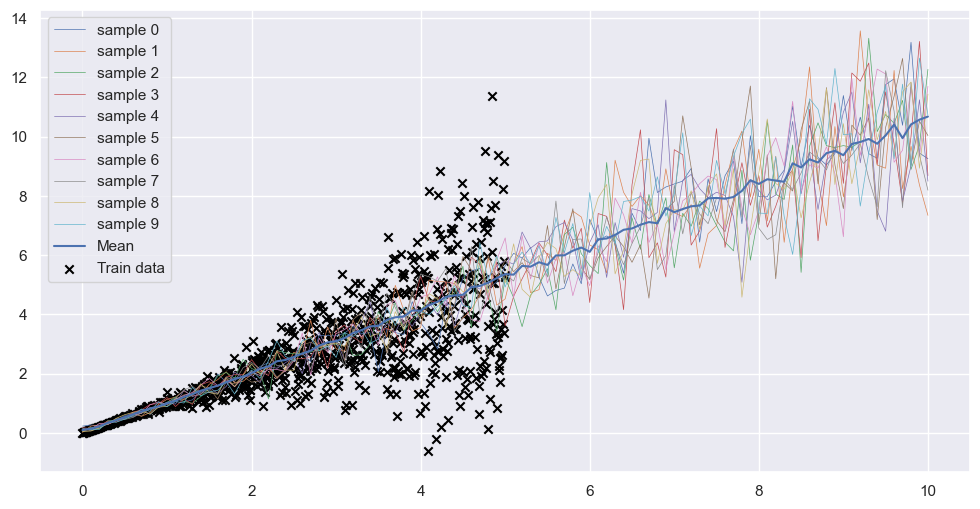

In [181]:
# plot 10 samples on the same figure
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(x_sample, mu_arr[:, i], linewidth=0.5, label=f'sample {i}')
plt.plot(x_sample, np.mean(mu_arr, axis=1), linewidth=1.5, label='Mean')
# plot data
plt.scatter(X_train, y_train, marker='x', color='black', label='Train data')
plt.legend()
plt.show()

In [149]:
var_arr = np.exp(var_arr)

mean_hat = np.mean(mu_arr, axis=1)
var_hat = np.mean(var_arr + np.square(mu_arr), axis=1) - np.square(mean_hat)

std_hat = np.sqrt(var_hat)

In [150]:
uncertainty_aleatoric = np.mean(var_arr, axis=1)
uncertainty_epistemic = np.var(mu_arr, axis=1)

uncertainty_aleatoric_std = np.sqrt(uncertainty_aleatoric)
uncertainty_epistemic_std = np.sqrt(uncertainty_epistemic)

uncertainty_total = np.sqrt(uncertainty_aleatoric + uncertainty_epistemic)

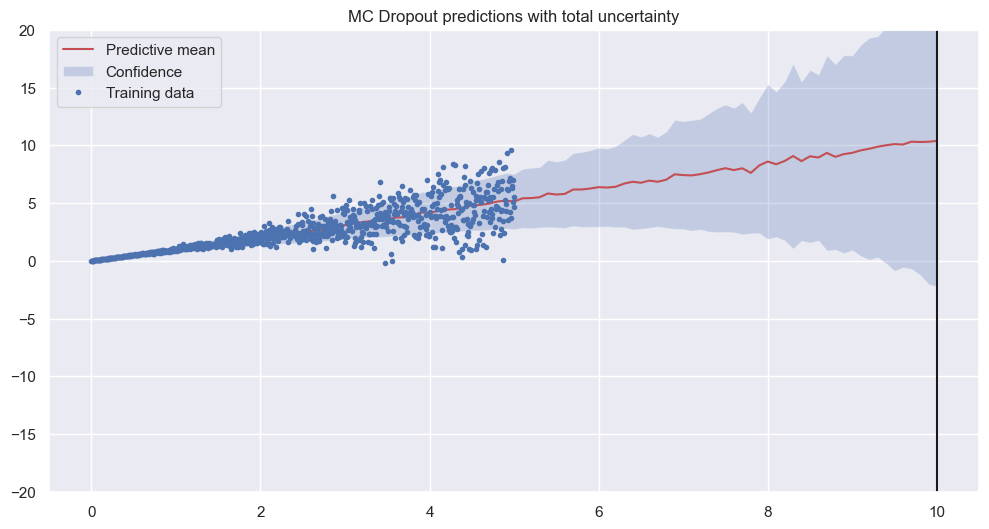

In [151]:
# plot predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_total, mean_hat + uncertainty_total, alpha=0.25, label='Confidence')
plt.plot(X_train, y_train, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with total uncertainty')
plt.show()

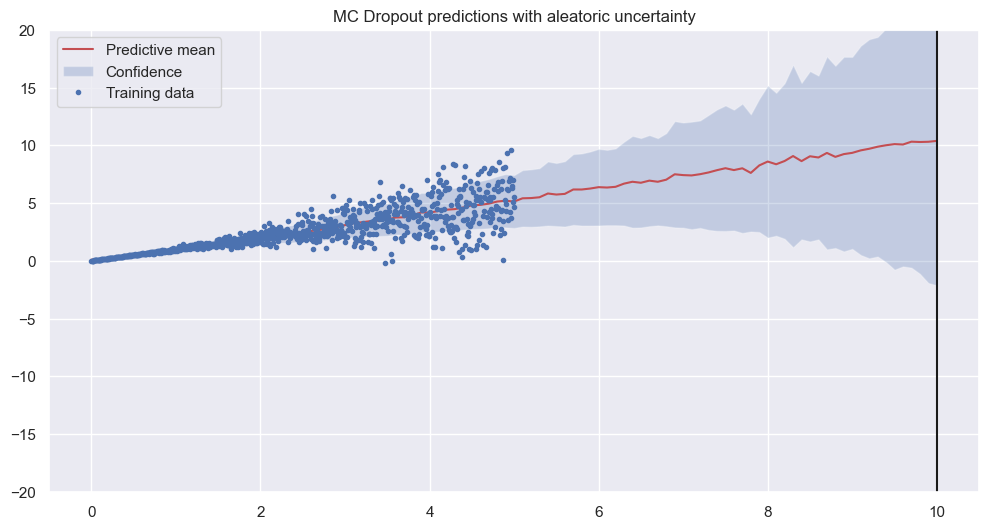

In [152]:
# plot predictions with confidence intervals, aleatoric uncertainty only
plt.figure(figsize=(12, 6))
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.plot(X_train, y_train, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with aleatoric uncertainty')
plt.show()

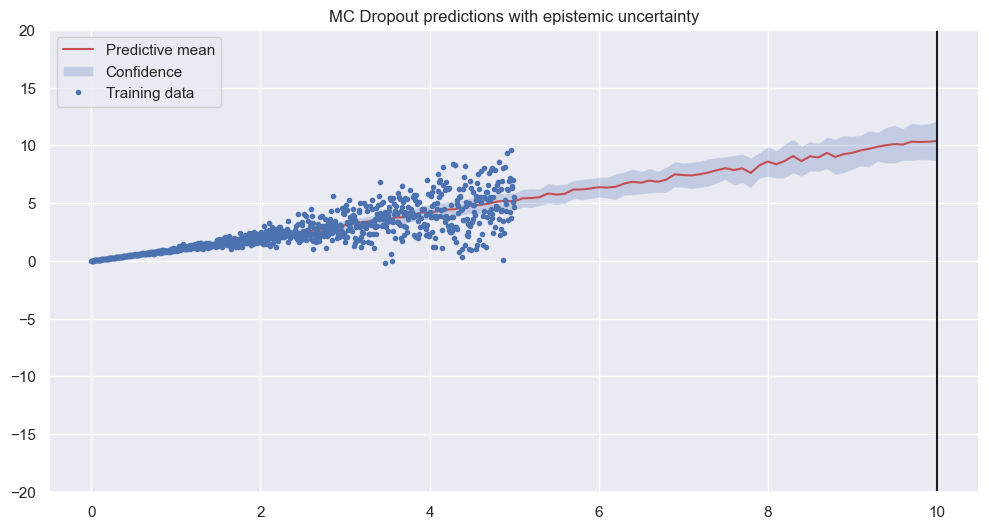

In [154]:
# plot predictions with confidence intervals, epistemic uncertainty only
plt.figure(figsize=(12, 6))
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_epistemic_std, mean_hat + uncertainty_epistemic_std, alpha=0.25, label='Confidence')
plt.plot(X_train, y_train, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with epistemic uncertainty')
plt.show()

## II. Ensembles

In [190]:
class MC_net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc_mu = nn.Linear(32, 1)
        self.fc_sigma = nn.Linear(32, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        mu = self.fc_mu(x)
        var = self.fc_sigma(x)
        return mu, var

In [191]:
test_loss = torch.tensor(0.0).to(device)

num_networks = 5

model_list = []
opt_list = []

for i in range(num_networks):
    model_list.append(MC_net().to(device))
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = 0.001, betas=(0.9, 0.999)))

In [192]:
for i in tqdm.tqdm(range(10_000)):
    for iter in range(num_networks):   
        # model_list[iter].train() 
        # create batch
        batch_x, batch_y = make_batch(X_train.shape[0], 32, X_train, y_train)
        
        # forward pass
        mu_train, var_train = model_list[iter](batch_x)
        
        # positivity constraint
        # sigma_train_pos = torch.log(1 + torch.exp(sigma_train)) + 1e-6
        
        # compute loss
        loss = torch.mean(
            0.5 * var_train + \
            0.5 * (torch.square(batch_y - mu_train)/torch.exp(var_train))) + 1
        
        # zero grad
        opt_list[iter].zero_grad()
    
        # backward pass
        loss.backward()

        # step
        opt_list[iter].step()
    
    # print each 500 epochs
    if i % 200 == 0:
        print(f"Epoch: {i}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f}")

  0%|          | 2/10000 [00:00<11:27, 14.54it/s]

Epoch: 0, train loss: 3.6469, test loss: 0.0000


  2%|▏         | 204/10000 [00:10<08:00, 20.37it/s]

Epoch: 200, train loss: 1.3637, test loss: 0.0000


  4%|▍         | 405/10000 [00:20<07:49, 20.42it/s]

Epoch: 400, train loss: 1.1543, test loss: 0.0000


  6%|▌         | 604/10000 [00:30<07:43, 20.25it/s]

Epoch: 600, train loss: 0.7470, test loss: 0.0000


  8%|▊         | 805/10000 [00:40<07:35, 20.19it/s]

Epoch: 800, train loss: 0.5873, test loss: 0.0000


 10%|█         | 1003/10000 [00:50<07:20, 20.41it/s]

Epoch: 1000, train loss: 1.0488, test loss: 0.0000


 12%|█▏        | 1204/10000 [01:00<07:51, 18.64it/s]

Epoch: 1200, train loss: 0.3821, test loss: 0.0000


 14%|█▍        | 1405/10000 [01:10<06:51, 20.90it/s]

Epoch: 1400, train loss: 1.2698, test loss: 0.0000


 16%|█▌        | 1605/10000 [01:20<06:46, 20.66it/s]

Epoch: 1600, train loss: 0.6752, test loss: 0.0000


 18%|█▊        | 1803/10000 [01:29<06:45, 20.20it/s]

Epoch: 1800, train loss: 0.7334, test loss: 0.0000


 20%|██        | 2004/10000 [01:39<06:20, 21.03it/s]

Epoch: 2000, train loss: 0.8033, test loss: 0.0000


 22%|██▏       | 2205/10000 [01:48<06:13, 20.86it/s]

Epoch: 2200, train loss: 0.2059, test loss: 0.0000


 24%|██▍       | 2403/10000 [01:58<06:02, 20.98it/s]

Epoch: 2400, train loss: 0.4468, test loss: 0.0000


 26%|██▌       | 2604/10000 [02:08<06:01, 20.43it/s]

Epoch: 2600, train loss: 0.3642, test loss: 0.0000


 28%|██▊       | 2803/10000 [02:17<05:46, 20.76it/s]

Epoch: 2800, train loss: 0.4439, test loss: 0.0000


 30%|███       | 3004/10000 [02:27<05:35, 20.84it/s]

Epoch: 3000, train loss: 0.6355, test loss: 0.0000


 32%|███▏      | 3205/10000 [02:37<05:28, 20.69it/s]

Epoch: 3200, train loss: 0.3070, test loss: 0.0000


 34%|███▍      | 3403/10000 [02:46<05:15, 20.91it/s]

Epoch: 3400, train loss: 1.0023, test loss: 0.0000


 36%|███▌      | 3604/10000 [02:56<05:06, 20.90it/s]

Epoch: 3600, train loss: 0.2935, test loss: 0.0000


 38%|███▊      | 3804/10000 [03:06<04:55, 21.00it/s]

Epoch: 3800, train loss: 0.6244, test loss: 0.0000


 40%|████      | 4005/10000 [03:17<04:52, 20.52it/s]

Epoch: 4000, train loss: 0.7604, test loss: 0.0000


 42%|████▏     | 4203/10000 [03:26<04:35, 21.03it/s]

Epoch: 4200, train loss: 0.7596, test loss: 0.0000


 44%|████▍     | 4405/10000 [03:36<04:25, 21.07it/s]

Epoch: 4400, train loss: 0.9769, test loss: 0.0000


 46%|████▌     | 4603/10000 [03:45<04:21, 20.62it/s]

Epoch: 4600, train loss: 0.7652, test loss: 0.0000


 48%|████▊     | 4804/10000 [03:55<04:07, 21.03it/s]

Epoch: 4800, train loss: 0.0017, test loss: 0.0000


 50%|█████     | 5005/10000 [04:05<03:58, 20.96it/s]

Epoch: 5000, train loss: -0.1634, test loss: 0.0000


 52%|█████▏    | 5203/10000 [04:14<03:48, 20.96it/s]

Epoch: 5200, train loss: 0.3352, test loss: 0.0000


 54%|█████▍    | 5403/10000 [04:24<03:40, 20.89it/s]

Epoch: 5400, train loss: 0.3191, test loss: 0.0000


 56%|█████▌    | 5604/10000 [04:33<03:30, 20.88it/s]

Epoch: 5600, train loss: 0.8415, test loss: 0.0000


 58%|█████▊    | 5804/10000 [04:43<03:19, 21.04it/s]

Epoch: 5800, train loss: 0.7992, test loss: 0.0000


 60%|██████    | 6003/10000 [04:53<03:19, 20.08it/s]

Epoch: 6000, train loss: 0.2301, test loss: 0.0000


 62%|██████▏   | 6204/10000 [05:03<03:01, 20.97it/s]

Epoch: 6200, train loss: 0.1825, test loss: 0.0000


 64%|██████▍   | 6405/10000 [05:13<02:49, 21.23it/s]

Epoch: 6400, train loss: 0.1955, test loss: 0.0000


 66%|██████▌   | 6605/10000 [05:23<02:41, 21.00it/s]

Epoch: 6600, train loss: 0.4054, test loss: 0.0000


 68%|██████▊   | 6805/10000 [05:33<02:35, 20.60it/s]

Epoch: 6800, train loss: 0.7844, test loss: 0.0000


 70%|███████   | 7003/10000 [05:42<02:22, 21.07it/s]

Epoch: 7000, train loss: 0.8750, test loss: 0.0000


 72%|███████▏  | 7204/10000 [05:52<02:13, 20.95it/s]

Epoch: 7200, train loss: 0.7449, test loss: 0.0000


 74%|███████▍  | 7405/10000 [06:02<02:10, 19.94it/s]

Epoch: 7400, train loss: 0.5346, test loss: 0.0000


 76%|███████▌  | 7604/10000 [06:13<01:56, 20.53it/s]

Epoch: 7600, train loss: 0.6522, test loss: 0.0000


 78%|███████▊  | 7803/10000 [06:23<01:47, 20.49it/s]

Epoch: 7800, train loss: 1.1446, test loss: 0.0000


 80%|████████  | 8003/10000 [06:33<01:40, 19.86it/s]

Epoch: 8000, train loss: 0.0165, test loss: 0.0000


 82%|████████▏ | 8204/10000 [06:43<01:27, 20.47it/s]

Epoch: 8200, train loss: 0.5652, test loss: 0.0000


 84%|████████▍ | 8405/10000 [06:53<01:17, 20.65it/s]

Epoch: 8400, train loss: 0.2796, test loss: 0.0000


 86%|████████▌ | 8603/10000 [07:03<01:08, 20.33it/s]

Epoch: 8600, train loss: 0.6717, test loss: 0.0000


 88%|████████▊ | 8804/10000 [07:13<01:01, 19.46it/s]

Epoch: 8800, train loss: 0.5781, test loss: 0.0000


 90%|█████████ | 9005/10000 [07:23<00:48, 20.37it/s]

Epoch: 9000, train loss: 0.6279, test loss: 0.0000


 92%|█████████▏| 9205/10000 [07:33<00:39, 20.32it/s]

Epoch: 9200, train loss: 0.5377, test loss: 0.0000


 94%|█████████▍| 9405/10000 [07:43<00:29, 20.49it/s]

Epoch: 9400, train loss: 0.9138, test loss: 0.0000


 96%|█████████▌| 9603/10000 [07:52<00:19, 20.43it/s]

Epoch: 9600, train loss: 0.4016, test loss: 0.0000


 98%|█████████▊| 9805/10000 [08:02<00:09, 20.63it/s]

Epoch: 9800, train loss: 0.3512, test loss: 0.0000


100%|██████████| 10000/10000 [08:12<00:00, 20.31it/s]


In [202]:
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

# model_list[0].eval()

mu_arr = np.zeros([X_sample_tensor.shape[0], num_networks])
var_arr = np.zeros([X_sample_tensor.shape[0], num_networks])

with torch.no_grad():
    for i in range(num_networks):
        model_list[i].eval()
        
        mu_pred, var_pred = model_list[i](X_sample_tensor)
        # positivity constraint
        # sigma_pred_pos = torch.log(1 + torch.exp(sigma_pred)) + 1e-6
        
        mu_sample = to_np(mu_pred)
        var_sample_log = to_np(var_pred)
        
        
        mu_arr[:, i] = np.reshape(mu_sample, (X_sample_tensor.shape[0]))
        var_arr[:, i] = np.reshape(var_sample_log, (X_sample_tensor.shape[0]))

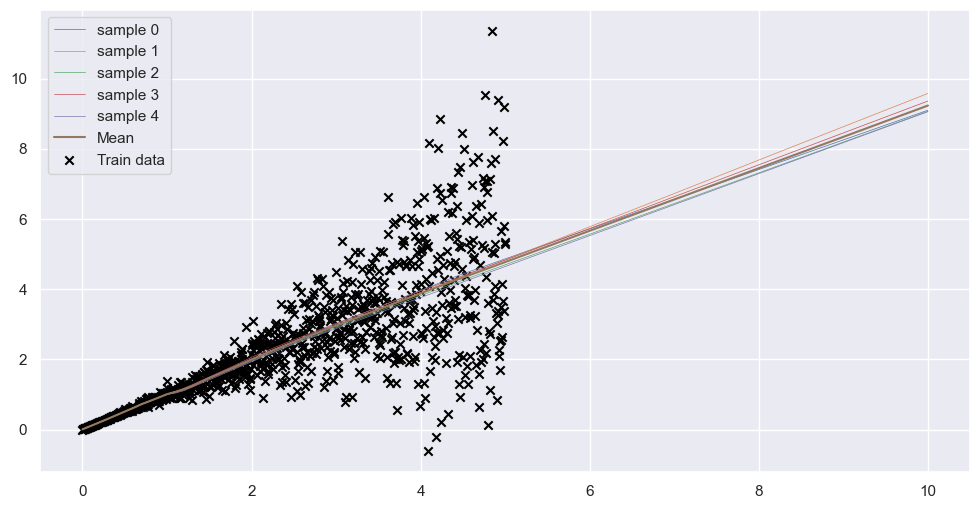

In [204]:
# plot 10 samples on the same figure
plt.figure(figsize=(12, 6))
for i in range(num_networks):
    plt.plot(x_sample, mu_arr[:, i], linewidth=0.5, label=f'sample {i}')
plt.plot(x_sample, np.mean(mu_arr, axis=1), linewidth=1.5, label='Mean')
# plot data
plt.scatter(X_train, y_train, marker='x', color='black', label='Train data')
plt.legend()
plt.show()

In [205]:
var_arr = np.exp(var_arr)

mean_hat = np.mean(mu_arr, axis=1)
var_hat = np.mean(var_arr + np.square(mu_arr), axis=1) - np.square(mean_hat)

std_hat = np.sqrt(var_hat)

In [206]:
uncertainty_aleatoric = np.mean(var_arr, axis=1)
uncertainty_epistemic = np.var(mu_arr, axis=1)

uncertainty_aleatoric_std = np.sqrt(uncertainty_aleatoric)
uncertainty_epistemic_std = np.sqrt(uncertainty_epistemic)

uncertainty_total = np.sqrt(uncertainty_aleatoric + uncertainty_epistemic)

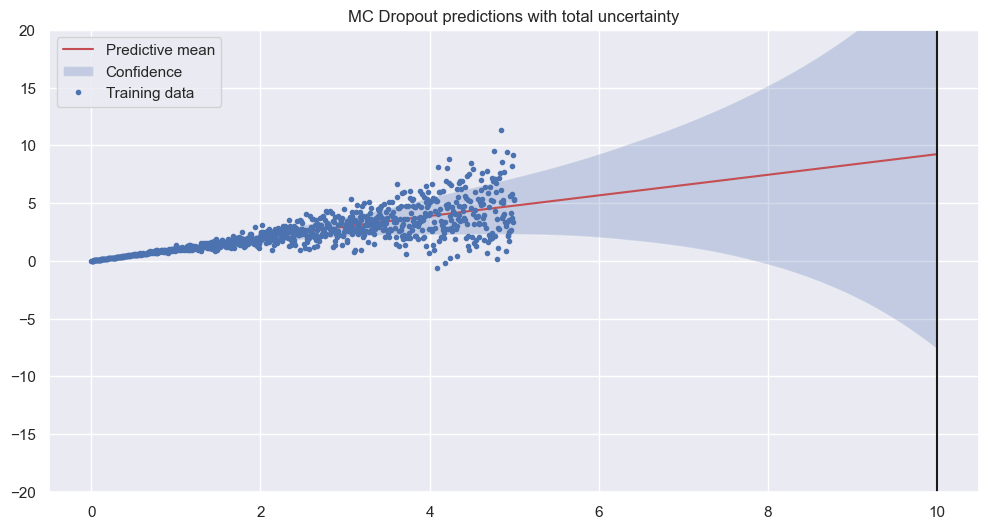

In [207]:
# plot predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_total, mean_hat + uncertainty_total, alpha=0.25, label='Confidence')
plt.plot(X_train, y_train, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with total uncertainty')
plt.show()

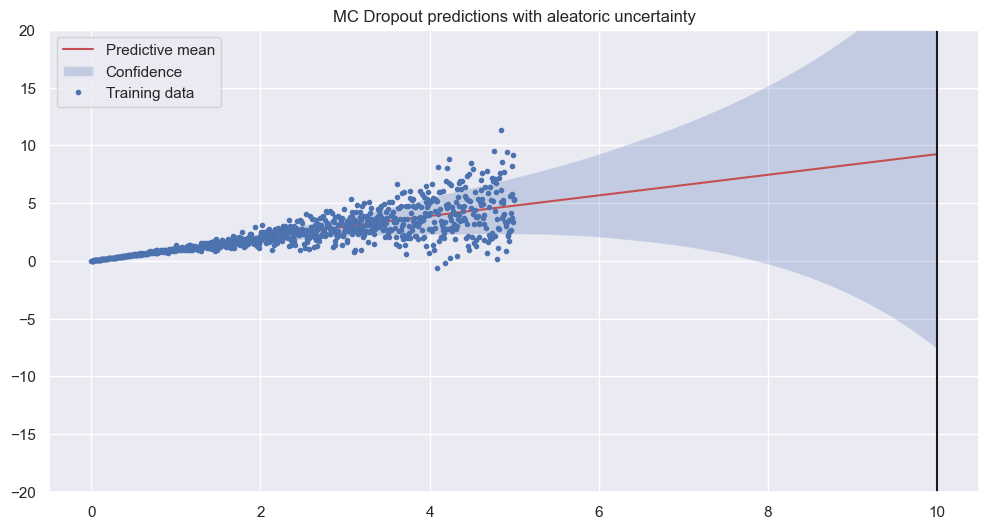

In [208]:
# plot predictions with confidence intervals, aleatoric uncertainty only
plt.figure(figsize=(12, 6))
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_aleatoric_std, mean_hat + uncertainty_aleatoric_std, alpha=0.25, label='Confidence')
plt.plot(X_train, y_train, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with aleatoric uncertainty')
plt.show()

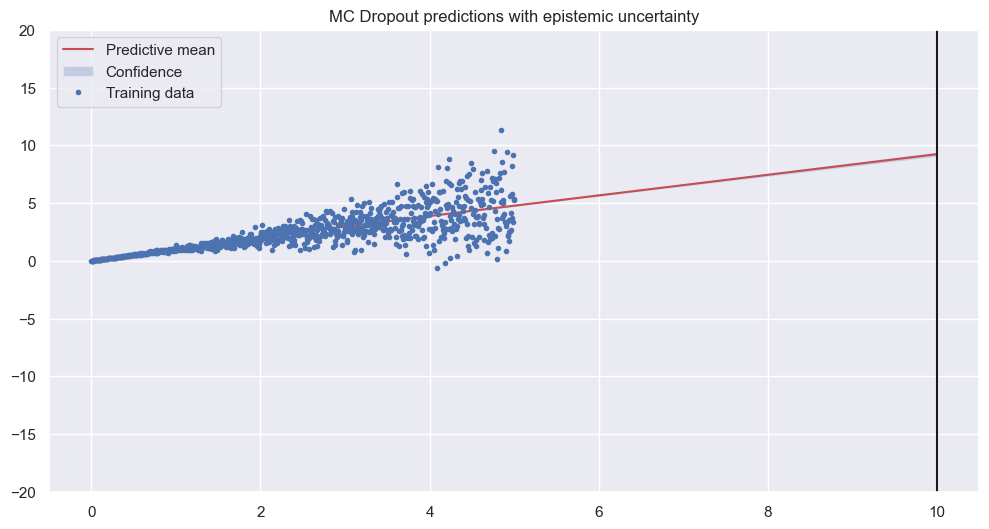

In [209]:
# plot predictions with confidence intervals, epistemic uncertainty only
plt.figure(figsize=(12, 6))
plt.plot(X_sample, mean_hat, 'r-', label='Predictive mean')
plt.fill_between(X_sample[:, 0], mean_hat - uncertainty_epistemic_std, mean_hat + uncertainty_epistemic_std, alpha=0.25, label='Confidence')
plt.plot(X_train, y_train, 'b.', label='Training data')
plt.ylim([-20, 20])
plt.axvline(x=10, color='k')
plt.legend()
plt.title('MC Dropout predictions with epistemic uncertainty')
plt.show()

Train the model

In [ ]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

In [ ]:
X_tensor = torch.from_numpy(X).float() # .to(device)
y_tensor = torch.from_numpy(y).float() # .to(device)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# convert to tensor
X_train_tensor = torch.from_numpy(X_train).float() # .to(device)
y_train_tensor = torch.from_numpy(y_train).float() # .to(device)
X_test_tensor = torch.from_numpy(X_test).float() # .to(device)
y_test_tensor = torch.from_numpy(y_test).float() # .to(device)

In [ ]:
X_train_tensor.unsqueeze(0).shape

In [ ]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 0.2,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.2,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.1,
}

In [ ]:
class DenseNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        return x

In [ ]:
# create the model for 2D data
model = DenseNN(1, 1)

dnn_to_bnn(model, const_bnn_prior_parameters)

In [ ]:
# loss, optimizer
mse_loss = nn.MSELoss()

EPOCHS = 10_000

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, verbose=True)

In [ ]:
# create pbar
pbar = tqdm.tqdm(total=EPOCHS, unit="epoch")

total_loss_list = []
loss1_list = []
loss2_list = []

for epoch in range(EPOCHS):
    model.train()
    # zero grad
    optimizer.zero_grad()
    
    # forward pass
    y_pred = model(X_train_tensor.unsqueeze(1))
    
    # compute loss
    loss1 = mse_loss(y_pred, y_train_tensor.unsqueeze(1))
    loss2 = get_kl_loss(model)
    
    total_loss = loss1 + 0.5 * loss2
    
    # backward pass + optimize
    total_loss.backward()
    optimizer.step()
    
    # update pbar
    pbar.set_description(f"Epoch {epoch+1}/{EPOCHS}")
    pbar.set_postfix({
        "total_loss": total_loss.item(),
        "MSE": loss1.item(),
        "BKL": loss2.item(),
        "LR": optimizer.param_groups[0]['lr']
    })
    
    # update scheduler
    # scheduler.step(total_loss)
    
    # save losses
    total_loss_list.append(total_loss.item())
    loss1_list.append(loss1.item())
    loss2_list.append(loss2.item())

# close pbar
pbar.close()

# evaluate the model
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor.unsqueeze(1))
    loss = mse_loss(y_pred, y_test_tensor.unsqueeze(1))
    
    print(f"MSE: {loss.item()}")

In [ ]:
# plot the losses
sns.set(rc={'figure.figsize':(10, 7)})

plt.plot(total_loss_list, label="Total loss")
plt.plot(loss1_list, label="MSE loss")
plt.plot(loss2_list, label="BKL loss")
plt.legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
plt.title("Losses")
plt.tight_layout()
plt.show()

In [ ]:
# compute predictions distribution 
model.eval()

with torch.no_grad():
    y_preds = []
    for _ in range(5_000):
        y_pred = model(X_test_tensor.unsqueeze(1))
        y_preds.append(y_pred.cpu().numpy())
        
    y_preds = np.array(y_preds)

y_preds = torch.from_numpy(y_preds).squeeze(2)

In [ ]:
# sort X_test_tensor and get indices
X_test_tensor_sorted, indices = torch.sort(X_test_tensor, dim=0)

# sort y_preds with previous indices
y_preds_sorted = y_preds[:, indices.cpu()] # type: ignore

In [ ]:
# compute mean and std of y_preds
y_preds_mean = y_preds_sorted.mean(dim=0) # type: ignore
y_preds_std = y_preds_sorted.std(dim=0) # type: ignore

In [ ]:
# y_preds_sorted[:5, :].squeeze(2)

In [ ]:
# plot the predictions distribution
sns.set(rc={'figure.figsize':(10, 7)})

plt.scatter(X_test, y_test, color="red", zorder=10, label="Observations", s=10)
plt.scatter(X_test_tensor_sorted.cpu().numpy(), y_preds_mean.numpy(), color="blue", label="Mean", s=5)
plt.fill_between(X_test_tensor_sorted.cpu().numpy().reshape(-1), (y_preds_mean.numpy() - y_preds_std.numpy()).flatten(), (y_preds_mean.numpy() + y_preds_std.numpy()).flatten(), color="blue", alpha=0.1, label="Std")
plt.legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
plt.title("Samples from posterior distribution")
plt.tight_layout()
plt.show()

In [ ]:
from bayesian_torch.utils.util import predictive_entropy, mutual_information

predictive_uncertainty = predictive_entropy(y_preds.numpy())
model_uncertainty = mutual_information(y_preds.numpy())

In [ ]:
predictive_uncertainty

In [ ]:
model_uncertainty

Tensorflow probability

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def f(x):
    return x + np.random.normal(0, 0.75, x.shape[0]) * x ** 2

def f(x):
    y = np.zeros_like(x)

    for i in range(len(x)):
        if -10 <= x[i] < -5:
            noise = np.random.normal(0, 0.5)
        elif -5 <= x[i] < 0:
            noise = np.random.normal(0, 0.012)
        elif 0 <= x[i] < 5:
            noise = np.random.normal(0, 1.5)
        elif 5 <= x[i] <= 10:
            noise = np.random.normal(0, 0.5)
        else:
            noise = 0
        
        mean = np.sin(x[i] / 2) + x[i] * np.cos(0.8 * x[i])
        y[i] = mean + noise
    
    return y



def get_train_and_test_splits(train_size, test_size, batch_size=1):
    dataset_size = train_size + 1000  # Assuming a larger dataset size
    
    # Generate input data
    x = np.random.uniform(low=-10, high=10, size=dataset_size)  # Adjust the range as needed
    
    # Generate target data using the function f(x)
    y = f(x)
    
    # plot 
    sns.set(rc={'figure.figsize':(10, 7)})
    plt.scatter(x, y, s=5)
    plt.title("Data")
    plt.show()
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
    # We shuffle with a buffer the same size as the dataset.
    dataset = dataset.shuffle(buffer_size=dataset_size)
    
    # Split the dataset into train and test
    train_dataset = dataset.take(train_size).batch(batch_size)
    test_dataset = dataset.skip(test_size).batch(batch_size)

    return train_dataset, test_dataset

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
hidden_units = [64, 64, 64]
learning_rate = 0.001
EPOCHS = 1000


def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")
    
    # plot the predictions and truth
    sns.set(rc={'figure.figsize':(10, 7)})
    
    x_test = np.linspace(-10, 10, 1000)
    y_pred = model.predict(x_test)
    
    plt.scatter(x_test, y_pred, s=5, label="Predictions")
    plt.scatter(x_test, f(x_test), s=5, label="Truth")
    plt.title("Predictions")
    plt.show()

In [ ]:
batch_size = 1
train_size = 300
test_size = 100
train_dataset, test_dataset = get_train_and_test_splits(train_size, test_size, batch_size)

In [ ]:
FEATURE_NAMES = [
    "x"
]

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

In [ ]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="relu")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()

In [ ]:
run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)

In [ ]:
sample = 10
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = baseline_model(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {predicted[idx][0]} - Actual: {targets[idx]}")

In [ ]:
def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

In [ ]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# def prior(kernel_size, bias_size, dtype=None):
#     """
#     This function should create the prior distribution, consisting of the 
#     "spike and slab" distribution that is described above. 
#     The distribution should be created using the kernel_size, bias_size and dtype
#     function arguments above.
#     The function should then return a callable, that returns the prior distribution.
#     """
#     n = kernel_size+bias_size  
#     prior_model = keras.Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
#     return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

# def posterior(kernel_size, bias_size, dtype=None):
#     """
#     This function should create the posterior distribution as specified above.
#     The distribution should be created using the kernel_size, bias_size and dtype
#     function arguments above.
#     The function should then return a callable, that returns the posterior distribution.
#     """
#     n = kernel_size + bias_size
#     return keras.Sequential([
#         tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
#         tfpl.IndependentNormal(n)
#     ])

In [ ]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )

In [ ]:
bnn_model_full = create_bnn_model(train_size)
run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)

compute_predictions(bnn_model_full)

In [ ]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

prob_bnn_model = create_probablistic_bnn_model(train_size)
run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

In [ ]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(lower[idx][0], 2)} - {round(upper[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )